In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SCtheory as kc
import SC

In [2]:
kbT0 = 86.17 * .11 # µeV
f0 = 6.7e9 # Hz
hw0 = 6.528e-4*2*np.pi*f0*1e-6 # µeV
y0 = 0 # detuning Q*df/f
Qi_sat = 1.2e5
Qc = 4.3e4
V = 96 #µm^3
supercond = SC.bTa
ak = .01
beta = 2

lmbda = 402 #nm
etapb = .59

In [3]:
# calculate excess quasiparticles due to photon, equilibrium quasiparticles and effective temperature
dNqp = etapb * 6.528e-4*2*np.pi* 3e8 / (lmbda * 1e-3) / supercond.D0
Nqp0 = V * kc.nqp(kbT0, supercond.D0, supercond)
kbTeff = kc.kbTeff((Nqp0 + dNqp)/V, supercond)

# calculate equilibrium complex conductivity, Qi, Lk and from that C and Lg (for later fres calc)
s10, s20 = kc.cinduct(hw0, kbT0, supercond)
Qi_Nqp0 = 2/(ak*beta) * s20/s10
Qi0 = Qi_Nqp0 * Qi_sat / (Qi_Nqp0 + Qi_sat)
Lk0 = np.imag(1/(s10-1j*s20))/(2*np.pi*f0)
C = ak/(f0**2*Lk0)
Lg = Lk0*(1/ak-1)

#calculate complex conductivities and excess quasiparticles during pulse (between kbT0 and kbTeff)
kbTarr = np.logspace(np.log10(kbT0), np.log10(kbTeff), 100)
s1, s2 = kc.cinduct(hw0, kbTarr, supercond)
Nqp = V * kc.nqp(kbTarr, supercond.D0, supercond)
exNqp = Nqp - Nqp0

In [4]:
# Make a S21 frequency sweep of twice the resonator linewidth
Q = Qc * Qi0 / (Qc + Qi0)
df_sweep = np.linspace(-(2 + y0)*f0/Q, (2 + y0)*f0/Q, 100)

S21 = kc.S21(Qi0, Qc, f0, df_sweep, f0)

S21min = Q/Qi0 # S21 at resonance
xc = (1 + S21min)/2 # middle of the circle

# Calculate Qi and f0 during pulse
Qi_Nqp = 2/(ak*beta) * s2/s1
Qiresp = Qi_Nqp * Qi_sat / (Qi_Nqp + Qi_sat)

Lk = np.imag(1/(s1-1j*s2))/(2*np.pi*f0)
fresp = 1/np.sqrt(C*(Lk + Lg))

# calculate the S21 response during pulse
S21resp = kc.S21(Qiresp, Qc, f0, y0/Q*f0 , fresp)

# Translate to amplitude and phase
dA = 1 - np.sqrt((S21resp.real - xc) ** 2 + S21resp.imag ** 2) / (1 - xc)
theta = np.arctan2(S21resp.imag, (xc - S21resp.real))

# Translate to R and X
x0 = Q / (2 * Qc)
R = 2 * ( 2*x0 * (S21resp.real - np.abs(S21resp)**2)/np.abs(1 - S21resp)**2 - (1 - 2*x0))
X = 4 * ( x0 * S21resp.imag / (np.abs(1 - S21resp)**2) - y0)

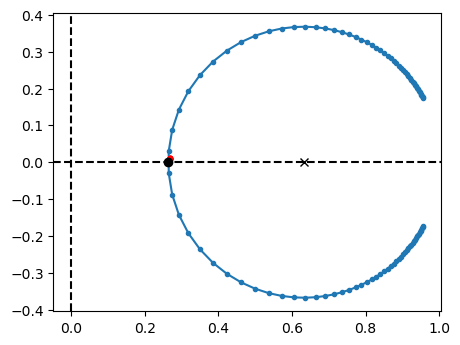

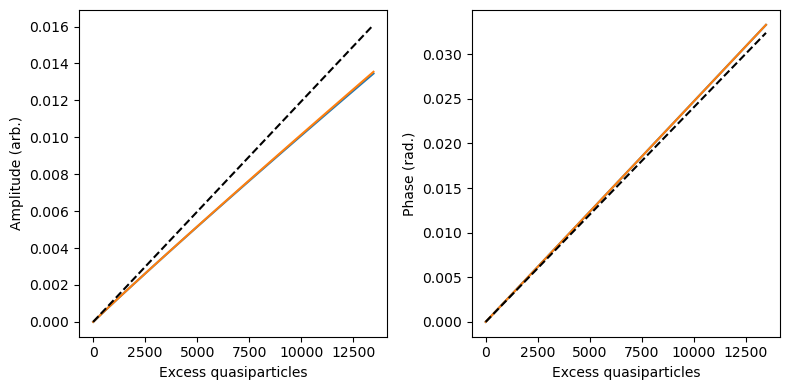

In [5]:
# plot in the circle
plt.figure(figsize=(5, 5))
plt.gca().set_aspect('equal')
plt.plot(S21.real, S21.imag, '.-')
plt.plot(S21resp.real, S21resp.imag, '.-', color='r')
plt.plot(S21min, 0, 'ko')
plt.plot(xc, 0, 'kx')
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')

# plot in absolute S21 and phase of S21
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# axs[0].plot(df_sweep, np.abs(S21))
# axs[0].plot(np.ones(len(kbTarr))*y0/Q*f0, np.abs(S21resp), 'r.')
# # axs[0].set_yscale('log')
# axs[1].plot(df_sweep, np.angle(S21))
# axs[1].plot(np.ones(len(kbTarr))*y0/Q*f0, np.angle(S21resp), 'r.')
# fig.tight_layout()

# plot amplitude and phase against excess quasiparticles
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(exNqp, dA)
axs[0].plot(exNqp, R)
resp = ak*beta*Q/(2*supercond.N0 * supercond.D0 * V)
axs[0].plot(exNqp, resp * np.sqrt(2*supercond.D0/hw0)/np.pi * exNqp,
           color='k', ls='--')
axs[0].set_ylabel('Amplitude (arb.)')
# axs[0].set_ylim(0, dA.max()*1.1)
axs[1].plot(exNqp, theta)
axs[1].plot(exNqp, X)
# axs[1].plot(exNqp, 2*np.tan(theta/2))
axs[1].plot(exNqp, resp * (1 + np.sqrt(2*supercond.D0/hw0)/np.pi) * exNqp,
            color='k', ls='--')
# axs[1].set_ylim(0, theta.max()*1.1)
axs[1].set_ylabel('Phase (rad.)')
for ax in axs:
    ax.set_xlabel('Excess quasiparticles')
fig.tight_layout()